In [1]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
import numpy as np
import pandas as pd
import networkx as nx
from multiprocessing.pool import Pool
from rdkit.Chem.rdchem import BondType
import os
import matplotlib.pylab as plt
import random
from tqdm import tqdm
import matplotlib

In [2]:
df_meta = pd.read_csv('data/metabolites_small.csv', index_col=0)
df_drug = pd.read_csv('data/druglike_small.csv', index_col=0)
df_tox = pd.read_csv('data/toxic_small.csv', index_col=0)
df_drug = df_drug.drop_duplicates('standard_smiles', keep='first')#不同drug种类有重复

meta_smi_list = list(df_meta['standard_smiles'].values)
drug_smi_list = list(df_drug['standard_smiles'].values) 
tox_smi_list = list(df_tox['standard_smiles'].values)

In [3]:
def judge_smi(smi, error_file = 'results/all_gapenergy_error.txt'):
    f = open(error_file, 'a+', buffering=1)
    try:
        mol = Chem.MolFromSmiles(smi)
    except:
        f.write(smi+"   cannot to mol"+'\n')
        return None
    try:
        bindnum = len(mol.GetBonds())
        if bindnum > 2:
            pass
        else:
            f.write(smi+'  num_bond < 3.'+'\n')
            return None
    except:
        f.write(smi+'   cannot get bond.' + '\n')
        return None

    try:
        mol = Chem.AddHs(mol)  # RDkit中默认不显示氢,向分子中添加H
    except:
        f.write(smi+ '  AddHs error.'+ '\n')
        return None
    try:
        Chem.Kekulize(mol)  # 向分子中添加芳香共轭键
    except:
        f.write(smi+ '  Addkekus error.' + '\n')
        return None
    
    return mol
def cal_atompairs_onesmi(smi, error_file = 'results/all_gapenergy_error.txt'):
    mol = judge_smi(smi, error_file)
    if mol == None:
        return None
    f = open(error_file, 'a+', buffering=1)
    atoms = [['H', 'H'], ['H', 'F'], ['H', 'Cl'], ['H', 'Br'], ['H', 'I'],
             ['C', 'H'], ['C', 'C'], ['C', 'N'], ['C', 'O'], ['C', 'F'], ['C', 'Cl'], ['C', 'Br'], ['C', 'I'], ['C', 'S'],
             ['N', 'H'], ['N', 'N'], ['N', 'F'], ['N', 'Cl'], ['N', 'Br'], ['N', 'O'],
             ['O', 'H'], ['O', 'O'], ['O', 'F'], ['O', 'Cl'], ['O', 'I'],
             ['F', 'F'], ['F', 'Cl'], ['F', 'Br'], ['Cl', 'Cl'], ['Cl', 'Br'], ['Br', 'Br'], ['I', 'I'], ['I', 'Cl'], ['I', 'Br'],
             ['S', 'H'], ['S', 'F'], ['S', 'Cl'], ['S', 'Br'], ['S', 'S'],
             ['Si', 'Si'], ['Si', 'H'], ['Si', 'C'], ['Si', 'O'],
             ['C', 'C'], ['C', 'C'], ['O', 'O'], ['C', 'O'], ['C', 'O'], ['N', 'O'], ['N', 'N'],
             ['N', 'N'], ['C', 'N'], ['C', 'N'],
             ['P', 'H'], ['P', 'Cl'], ['P', 'Br'], ['P', 'O'], ['P', 'O'], ['P', 'P'], ['P', 'C'],
             ['S', 'C'], ['S', 'O'], ['S', 'O'],
             ['S','N'], ['S','P'], ['S','P']]
    bondtypes = [BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, # 5
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #9
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #6
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #5
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #9
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #5
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #4
                 BondType.DOUBLE, BondType.TRIPLE, BondType.DOUBLE, BondType.DOUBLE, BondType.TRIPLE, BondType.DOUBLE, BondType.DOUBLE, #7
                 BondType.TRIPLE, BondType.TRIPLE, BondType.DOUBLE, #3
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.DOUBLE, BondType.SINGLE, BondType.SINGLE, #7
                 BondType.DOUBLE, BondType.SINGLE, BondType.DOUBLE, #3
                 BondType.SINGLE, BondType.SINGLE, BondType.DOUBLE #3
                 ]
    energies = [432, 565, 427, 363, 295, 413, 347, 305, 358, 485, 339, 276, 240, 259, 391, 160, 272, 200, 243, 201, 467,
                146, 190, 203, 234,
                154, 253, 237, 239, 218, 193, 149, 208, 175, 347, 327, 253, 218, 266, 340, 393, 360, 452, 614, 839, 495,
                745, 1072, 607, 418,
                941, 891, 615, 322, 331, 272, 410, 585, 213, 305, 536, 226, 460,
                121, 463, 389]
    # newbondenergy = []
    # oldbondenergy = []
    list_of_numatompair = []
    for bond in mol.GetBonds():  # 读取mol中所有化学键，得到所有键的列表，遍历
        flag = False
        bondenergy = 0.0
        beginnum = mol.GetAtomWithIdx(bond.GetBeginAtomIdx()).GetIdx()
        endnum = mol.GetAtomWithIdx(bond.GetEndAtomIdx()).GetIdx() #index在一个分子内唯一
        atompair = sorted([mol.GetAtomWithIdx(bond.GetBeginAtomIdx()).GetSymbol(),mol.GetAtomWithIdx(bond.GetEndAtomIdx()).GetSymbol()])

        for i in range(len(atoms)):  # 一个个试，atoms是数据库里的已知所有的原子对
            if (atompair == sorted(atoms[i])) and (bond.GetBondType() == bondtypes[i]):  # 一个个比对
                flag = True
                bondenergy = energies[i]
                bondname = atompair[0]+'-'+atompair[1]+'-'+str(bond.GetBondType())
                # newbondenergy.append(bondenergy / ExactbondWet[i])
                # oldbondenergy.append(bondenergy)
        if flag == True:
            list_of_numatompair.append([beginnum, endnum, bondenergy, bondname])
        else:
            f.write(smi+f"  {atompair[0]} and {atompair[1]}, {bond.GetBondType()} cannot calculate bond energy."+ '\n')
            return None #结束

    # newstd = np.std(newbondenergy)
    # newnbe = sum(newbondenergy) / len(mol1.GetBonds())
    # oldstd = np.std(oldbondenergy)
    # oldnbe = sum(oldbondenergy) / Descriptors.ExactMolWt(mol1)    
    return list_of_numatompair #[[beginnum, endnum, bondenergy], [beginnum, endnum, bondenergy], ...]

def get_graph_onesmi(smi, error_file = 'results/all_gapenergy_error.txt'):
    list_of_numatompair = cal_atompairs_onesmi(smi, error_file)
    if list_of_numatompair == None:
        return None
    f = open(error_file, 'a+', buffering=1)
    G = nx.Graph()
    num = len(list_of_numatompair)
    # nodelist = [[i, list_of_numatompair[i][2]] for i in range(num)] #化学键作点，键能是点的属性
    edgelist = []
    for i in range(num):
        a1, b1 = list_of_numatompair[i][0], list_of_numatompair[i][1]
        for x in range(i+1, num): #这样就不会有重复？
            if list_of_numatompair[x][0] == a1 or list_of_numatompair[x][1] == a1:
                edgelist.append((i, x))
            if list_of_numatompair[x][0] == b1 or list_of_numatompair[x][1] == b1:
                edgelist.append((i, x))

    G.add_nodes_from([i for i in range(num)]) #有num个点
    G.add_edges_from(edgelist)

    length_source_target = dict(nx.shortest_path_length(G))
    max_dimension = 65
    gap_and_energy = {i+1:[] for i in range(max_dimension)} #距离从1开始
    gap_and_bondname = {i+1:[] for i in range(max_dimension)}
    for i in range(num):
        for x in range(i+1,num):
            try:
                gap = length_source_target[i][x]
                # startenergy = nodelist[idx1][1]
                # endenergy = nodelist[idx2][1]
                deltaenergy = abs(list_of_numatompair[i][2]-list_of_numatompair[x][2])
                deltabondname = sorted([list_of_numatompair[i][3], list_of_numatompair[x][3]])
                gap_and_energy[gap].append(deltaenergy)
                gap_and_bondname[gap].append(deltabondname[0]+'~'+deltabondname[1])

            except:
                f.write(smi+f"  exist node without path."+ '\n')
                return None

    #如果需要求平均
    # gap_and_energy = [np.mean(gap_and_energy[i+1]) if len(gap_and_energy[i+1])>0 else np.nan for i in range(max_dimension)]
    return (smi, gap_and_energy, gap_and_bondname)


In [13]:
def multiprocess_cal_gapenergy(smi_list, processes_num=40):
    print('smiles数量: ', len(smi_list))
    new_smi_list, gap_energy, gap_bondname = [], [], []
    # random.shuffle(smi_list)
    with Pool(processes_num) as p:
        outputs = p.map(get_graph_onesmi, tqdm(random.sample(smi_list, 2000)))
        print("多进程结束")
        for res in outputs:
            if res != None:
                new_smi_list.append(res[0])
                gap_energy.append(res[1])
                gap_bondname.append(res[2])
    return new_smi_list, gap_energy, gap_bondname

new_smi_list, gap_energy, gap_bondname = multiprocess_cal_gapenergy(tox_smi_list) #4min56

smiles数量:  3404


  0%|          | 0/2000 [00:00<?, ?it/s][12:26:14] WARNING: not removing hydrogen atom without neighbors
[12:26:14] WARNING: not removing hydrogen atom without neighbors
[12:26:14] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 2000/2000 [00:00<00:00, 44885.03it/s]


多进程结束


In [14]:
#随机抽取1000个，研究第一个第二个和第三个的energy的组成
def energy_analyze_onegap(index, all_gapen, num=1000):
    gapen_select = random.sample(all_gapen,num)
    print('gapen_select:', len(gapen_select))
    energy_gap = []
    for en in gapen_select:
        energy_gap.extend(en[index])
    energy_gap = np.array(energy_gap)
    # energy_gap =energy_gap[~np.isnan(energy_gap)]
    # print(len(energy_gap), 'mean:', np.mean(energy_gap))
    energy_gap = pd.DataFrame(pd.Series(energy_gap).value_counts().reset_index()).rename(columns={'index':'energy',0:'counts'})
    return energy_gap


# energy_gap1, energy_gap2, energy_gap3, energy_gap4 = \
#     energy_analyze_onegap(1, gap_energy),energy_analyze_onegap(2, gap_energy), \
#         energy_analyze_onegap(3, gap_energy), energy_analyze_onegap(4, gap_energy)   
energy_gap_dfs = [energy_analyze_onegap(i+1, gap_energy) for i in range(4)]

gapen_select: 1000
gapen_select: 1000
gapen_select: 1000
gapen_select: 1000


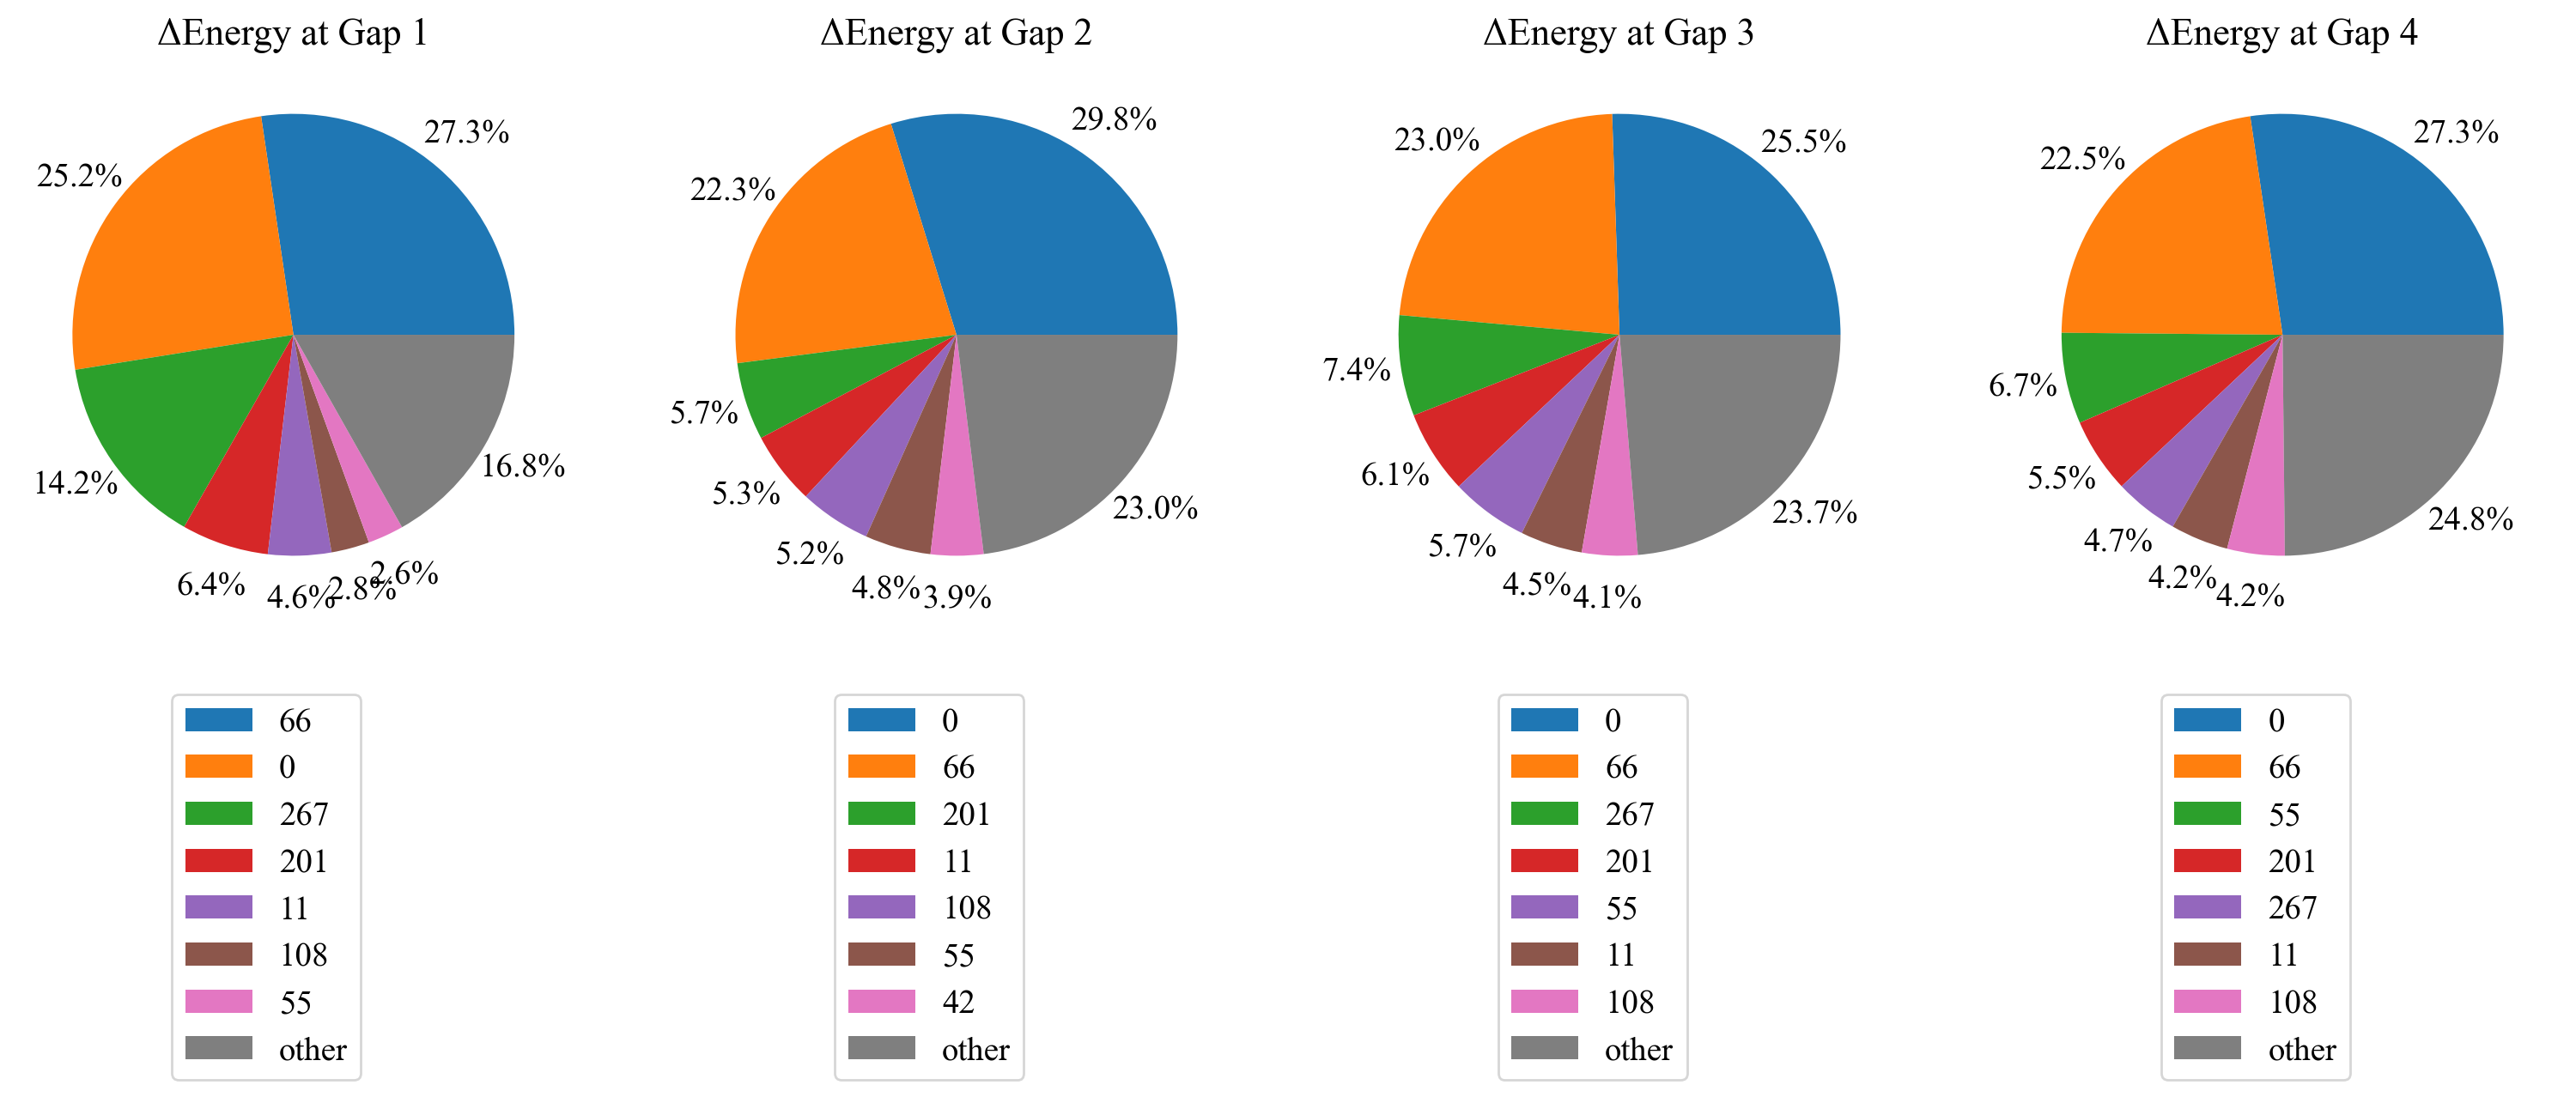

In [15]:
def draw_multi_pie(dfs:list, num=7):
    dfs_value_counts = []
    for df in dfs:
        df_value_counts = df.iloc[:num+1,:].copy() #必须有copy
        df_value_counts.iloc[num, :] = ['other', sum(df.iloc[num:,1])]
        dfs_value_counts.append(df_value_counts)
        
    plt.rc('font',family='Times New Roman')
    plt.figure(figsize=(16,8),dpi=200)
    plt.subplots_adjust(left=0.025, bottom=0.25, right=0.95,top=1.2, wspace=0.2, hspace=0.1)
    for i in range(len(dfs)):
        plt.subplot(1,len(dfs),i+1 )
        plt.pie(x=dfs_value_counts[i].iloc[:,1],\
               autopct = '%1.1f%%',pctdistance = 1.2, labeldistance = 0.8, textprops={'size':14},counterclock=True)
        plt.legend(labels = dfs_value_counts[i].iloc[:,0], loc='center left', bbox_to_anchor=(0.25,-0.5), prop={'size':14} )
        # (-0.05,-0.5) (0.25,-0.5)
        plt.title(f"ΔEnergy at Gap {i+1}", fontdict={'size':16}) #ΔEnergy
    plt.savefig("pictures/tox_Δenergy_at_gap.png",dpi=200)
    plt.show()

draw_multi_pie(energy_gap_dfs)

In [ ]:
#画图


为什么第一个到第二个降低那么多 第二个到第三个升高了？
观察里面的成分？

gapen_select: 1000
82531 mean: 102.6805927469678
gapen_select: 1000
123111 mean: 85.92042953107358
gapen_select: 1000
143662 mean: 98.68130751346912
gapen_select: 1000
136867 mean: 93.1529879371945


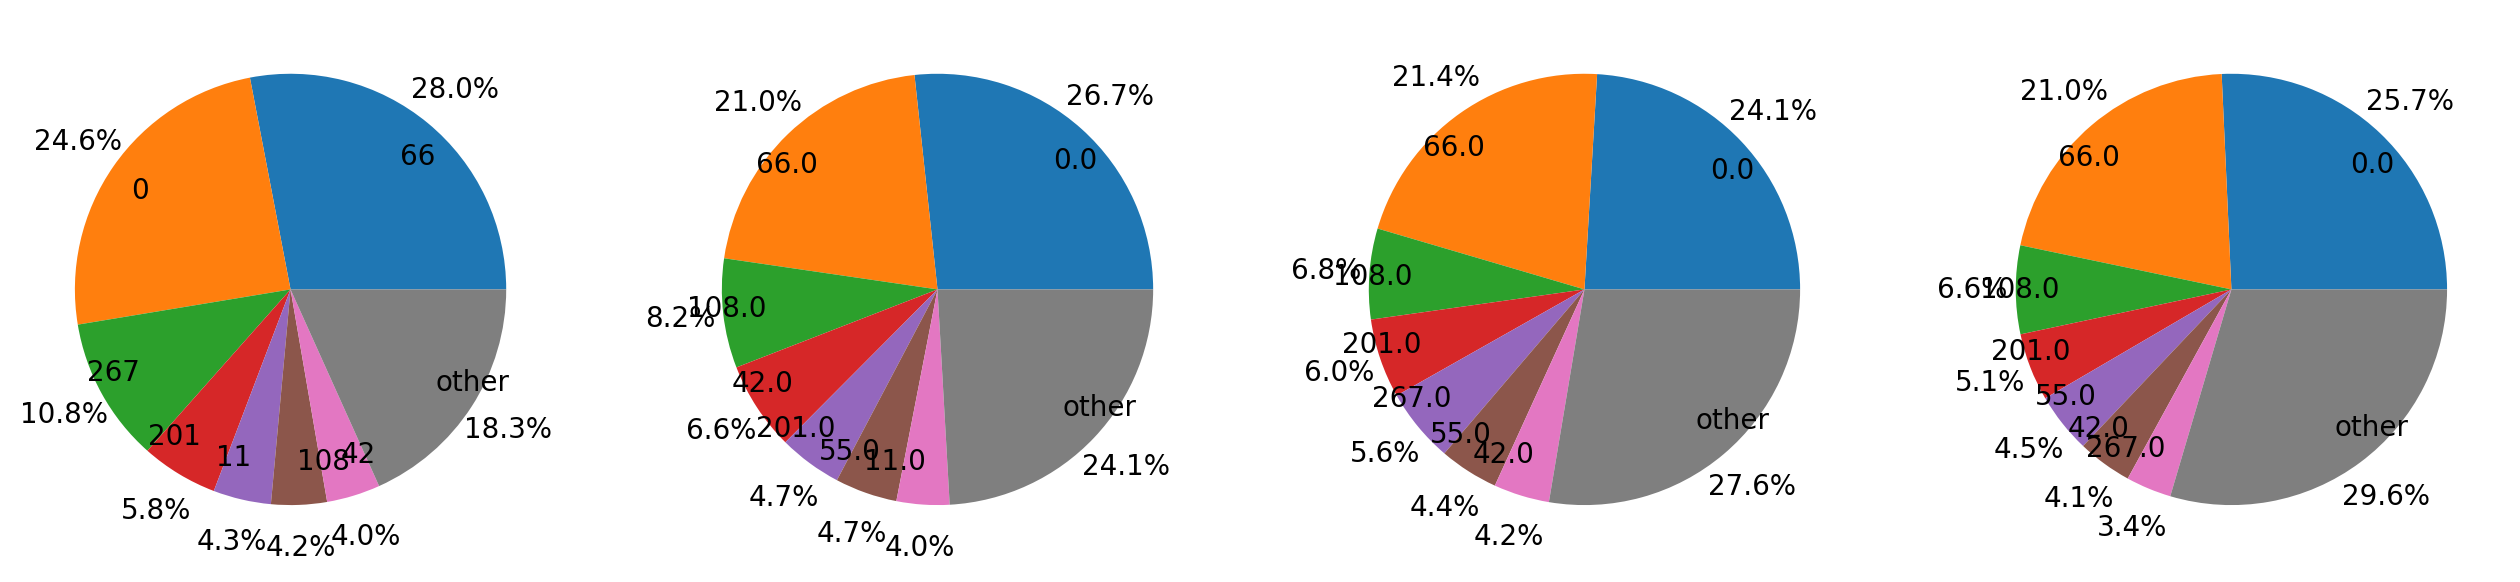

In [38]:
energy_gap1, energy_gap2, energy_gap3, energy_gap4 = \
    energy_analyze_onegap(0, drug_gapen),energy_analyze_onegap(1, drug_gapen), \
        energy_analyze_onegap(2, drug_gapen), energy_analyze_onegap(3, drug_gapen) 

draw_multi_pie([energy_gap1, energy_gap2, energy_gap3, energy_gap4])

gapen_select: 1000
62364 mean: 105.30299531781156
gapen_select: 1000
89097 mean: 80.27153551746973
gapen_select: 1000
106819 mean: 95.26678774375345
gapen_select: 1000
97503 mean: 88.78131954914208


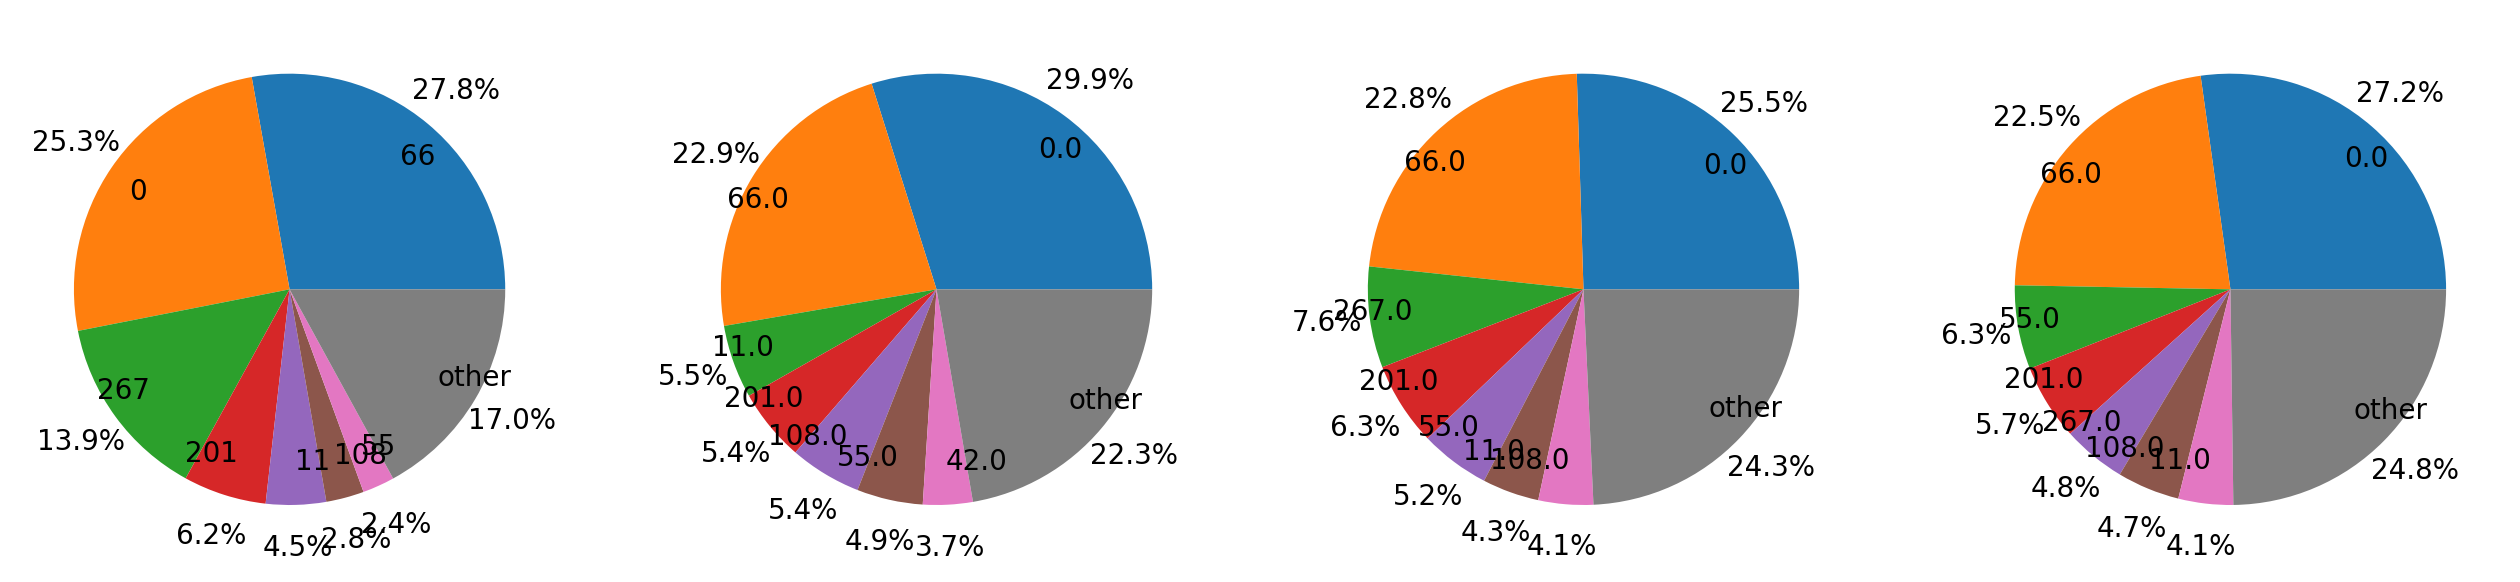

In [39]:
energy_gap1, energy_gap2, energy_gap3, energy_gap4 = \
    energy_analyze_onegap(0, tox_gapen),energy_analyze_onegap(1, tox_gapen), \
        energy_analyze_onegap(2, tox_gapen), energy_analyze_onegap(3, tox_gapen) 

draw_multi_pie([energy_gap1, energy_gap2, energy_gap3, energy_gap4])

In [2]:
energies = np.array([432, 565, 427, 363, 295, 413, 347, 305, 358, 485, 339, 276, 240, 259, 391, 160, 272, 200, 243, 201, 467,
            146, 190, 203, 234,
            154, 253, 237, 239, 218, 193, 149, 208, 175, 347, 327, 253, 218, 266, 340, 393, 360, 452, 614, 839, 495,
            745, 1072, 607, 418,
            941, 891, 615, 322, 331, 272, 410, 585, 213, 305, 536, 226, 460,
            121, 463, 389])
energies_row = np.expand_dims(energies, 0).repeat(energies.shape[0], axis=0)
energies_col = np.expand_dims(energies, 1).repeat(energies.shape[0], axis=1)
diff_energy_df = pd.DataFrame(np.abs(energies_row - energies_col), index=energies, columns=energies)
diff_energy_df.index.astype(str)
diff_energy_df.columns.astype(str)
diff_energy_df

,432,565,427,363,295,413,347,305,358,485,...,410,585,213,305,536,226,460,121,463,389
432,0,133,5,69,137,19,85,127,74,53,...,22,153,219,127,104,206,28,311,31,43
565,133,0,138,202,270,152,218,260,207,80,...,155,20,352,260,29,339,105,444,102,176
427,5,138,0,64,132,14,80,122,69,58,...,17,158,214,122,109,201,33,306,36,38
363,69,202,64,0,68,50,16,58,5,122,...,47,222,150,58,173,137,97,242,100,26
295,137,270,132,68,0,118,52,10,63,190,...,115,290,82,10,241,69,165,174,168,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,206,339,201,137,69,187,121,79,132,259,...,184,359,13,79,310,0,234,105,237,163
460,28,105,33,97,165,47,113,155,102,25,...,50,125,247,155,76,234,0,339,3,71
121,311,444,306,242,174,292,226,184,237,364,...,289,464,92,184,415,105,339,0,342,268
463,31,102,36,100,168,50,116,158,105,22,...,53,122,250,158,73,237,3,342,0,74


In [4]:
sum(pd.Series(np.abs(energies_row - energies_col).flatten()).duplicated()) #4356

3766